# <center><p style ="color: royalblue;">Heart Disease Prediction</p></center>

<center>>>> Nguyễn Ngọc Trí Vĩ <<<

Link dataset: https://www.kaggle.com/datasets/volodymyrgavrysh/heart-disease

### Import thư viện

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import tkinter as tk
import pyodbc

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split


from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from keras.models import Sequential
from keras.layers import Dense

### Đọc và xử lý dữ liệu

#### Đọc dữ liệu từ file csv

In [2]:
df = pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


#### Biến các thuộc tính phân loại thành dạng onehot

In [3]:
# Biến các thuộc tính phân loại thành dạng one hot
a = pd.get_dummies(df['cp'], prefix = "cp")
b = pd.get_dummies(df['thal'], prefix = "thal")
c = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, a, b, c]
df = pd.concat(frames, axis = 1)

# Bỏ các thuộc tính cũ đi
df = df.drop(columns = ['cp', 'thal', 'thal_0', 'slope'])

# Đổi tên các loại theo tên gọi
df = df.rename(columns={'cp_0':'typical_angina_pain','cp_1':'atypical_angina_pain','cp_2':'non-anginal_pain','cp_3':'asymptomatic_pain',
                       'slope_0':'upsloping_st', 'slope_1':'flat_st', 'slope_2':'downsloping_st',
                       'thal_1': 'thalassemia_normal', 'thal_2': 'thalassemia_fixed', 'thal_3': 'thalassemia_reversable'})

df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,typical_angina_pain,atypical_angina_pain,non-anginal_pain,asymptomatic_pain,thalassemia_normal,thalassemia_fixed,thalassemia_reversable,upsloping_st,flat_st,downsloping_st
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,0,1,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,0,1,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,0,1,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,0,1,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,1,123,1,0.2,0,...,1,0,0,0,0,0,1,0,1,0
299,45,1,110,264,0,1,132,0,1.2,0,...,0,0,0,1,0,0,1,0,1,0
300,68,1,144,193,1,1,141,0,3.4,2,...,1,0,0,0,0,0,1,0,1,0
301,57,1,130,131,0,1,115,1,1.2,1,...,1,0,0,0,0,0,1,0,1,0


#### Correlation map

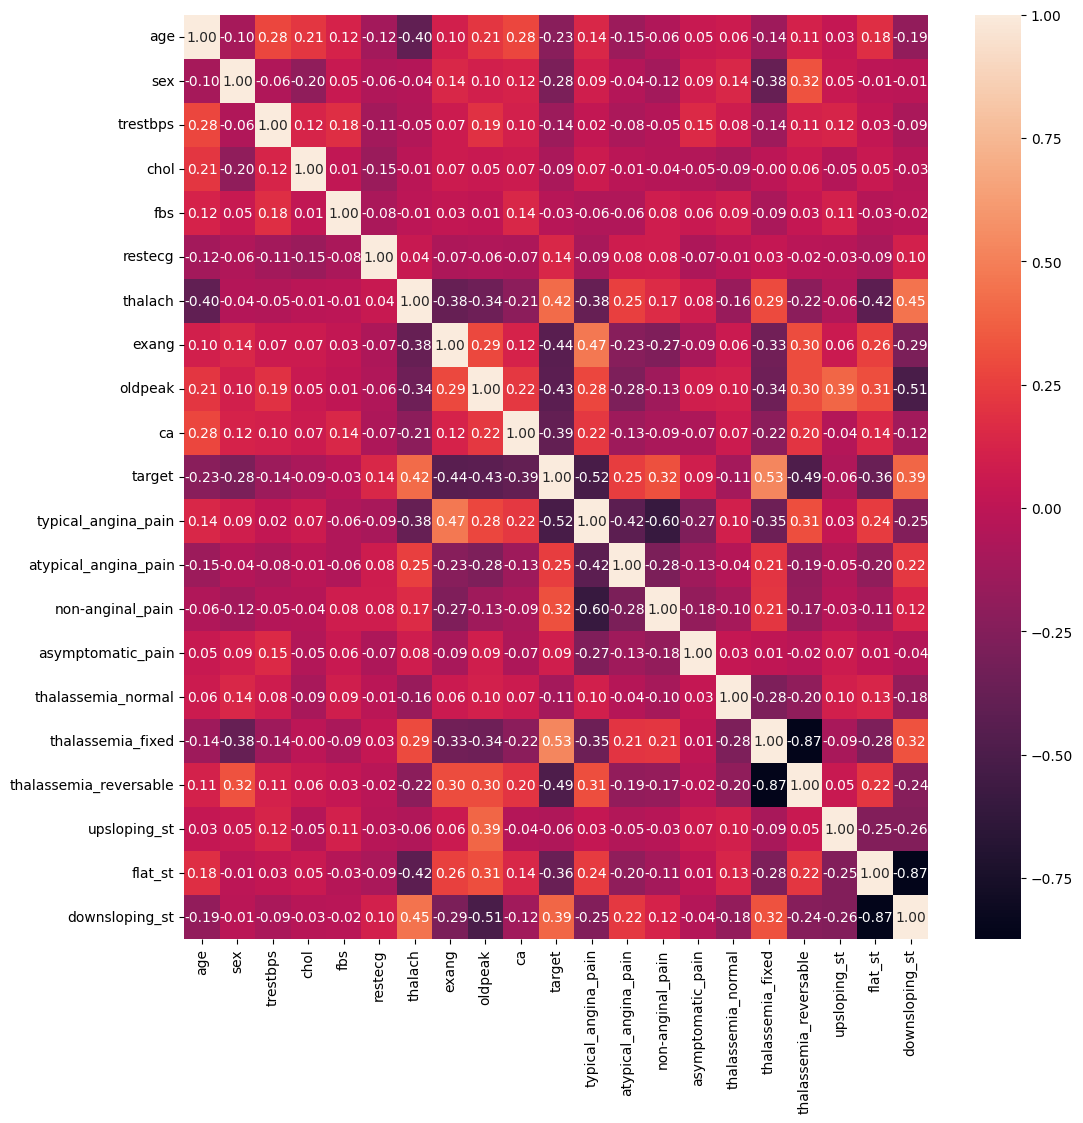

In [4]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True,fmt='.2f')
plt.show()

#### Chuẩn hóa dữ liệu và tách thành dữ liệu thành 2 mảng data và label

In [5]:
x_data = df.drop(['target'], axis=1)

# Chuẩn hóa dữ liệu theo kiểu Max min
X = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values
y = df['target']

c:\Users\kingg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\kingg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


#### Chia dữ liệu thành 8 phần train 2 phần test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## <center>```Ứng dụng các mô hình học máy để chuẩn đoán bệnh tim```</center>

### Dùng SVM

Accuracy: 0.803


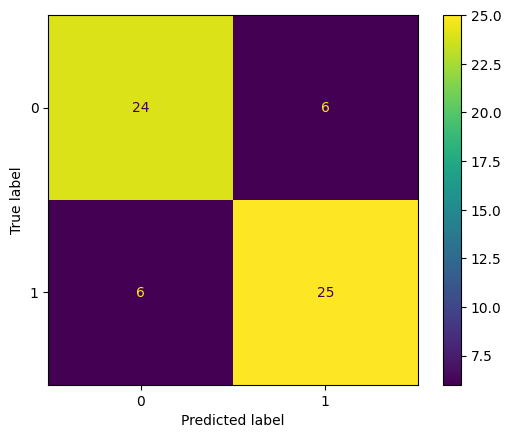

In [7]:
svc=SVC(kernel= 'rbf', gamma = 'scale' ,random_state=42)
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)

svm_recall = round(recall_score(y_test,svm_pred,average='weighted'),3)

acc = accuracy_score(y_test, svm_pred)
print ("Accuracy: %.3f" % acc)

cm = confusion_matrix(y_test, svc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)

disp.plot()

Vẽ ROC cho các gamma của SVM

gamma = 0.01  accuracy = 0.85   AUC = 0.89
gamma = 0.1  accuracy = 0.80   AUC = 0.87
gamma = 0.2  accuracy = 0.80   AUC = 0.86
gamma = 1  accuracy = 0.80   AUC = 0.83
gamma = scale  accuracy = 0.80   AUC = 0.86
gamma = auto  accuracy = 0.80   AUC = 0.88


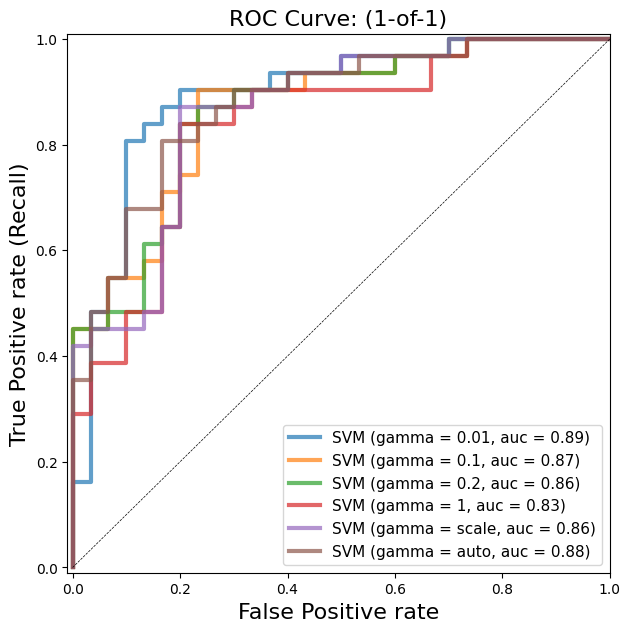

In [8]:
plt.figure(figsize = (7,7))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])

for g in [0.01, 0.1, 0.20, 1, 'scale', 'auto']:
    svm = SVC(gamma=g).fit(X_train, y_train)
    y_score_svm = svm.decision_function(X_test)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    accuracy_svm = svm.score(X_test, y_test)
    print("gamma = {}  accuracy = {:.2f}   AUC = {:.2f}".format(g, accuracy_svm, 
                                                                    roc_auc_svm))
    plt.plot(fpr_svm, tpr_svm, lw=3, alpha=0.7, 
             label='SVM (gamma = {}, auc = {:0.2f})'.format(g, roc_auc_svm))

plt.xlabel('False Positive rate', fontsize=16)
plt.ylabel('True Positive rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC Curve: (1-of-1)', fontsize=16)

plt.show()

### Dùng Extreme Gradient Boosted Decision Tree

accuracy: 0.7704918032786885


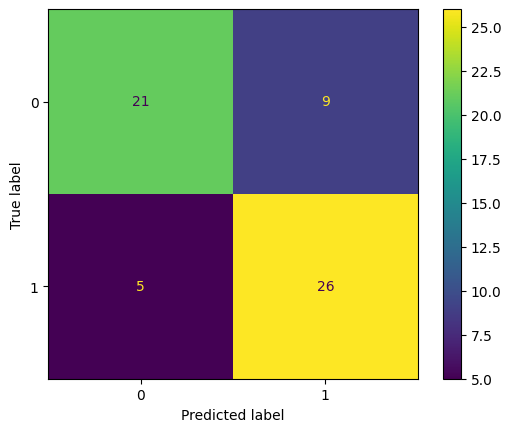

In [9]:
model = XGBClassifier()
 
model.fit(X_train,y_train)
 
predict_train = model.predict(X_train)
 
predict_test = model.predict(X_test)

xgb_recall = round(recall_score(y_test, predict_test, average='weighted'),3)

accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy:', accuracy_test)

cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()

### Dùng Naive Bayes

#### Dùng Gaussian Naive Bayes

accuracy: 0.7540983606557377


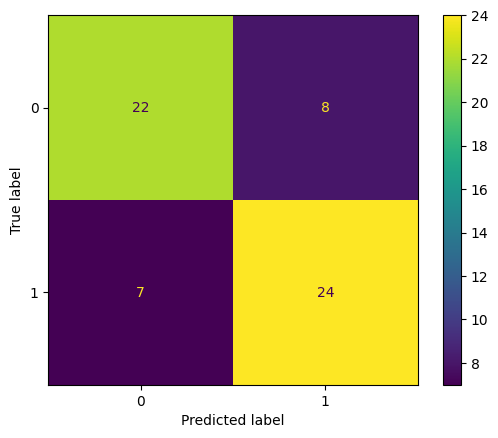

In [10]:
model = GaussianNB()
 
model.fit(X_train,y_train)
 
predict_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train,predict_train)
 
predict_test = model.predict(X_test)

gaussiannb_recall = round(recall_score(y_test, predict_test, average='weighted'),3)

accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy:', accuracy_test)

cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()

#### Dùng Bernoulli Naive Bayes

accuracy: 0.819672131147541


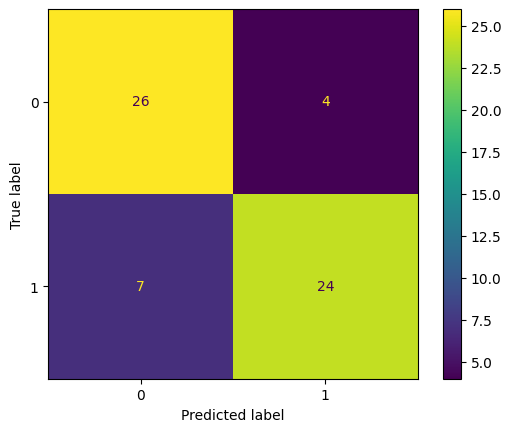

In [11]:
model = BernoulliNB()
 
model.fit(X_train,y_train)
 
predict_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train,predict_train)

predict_test = model.predict(X_test)

bernoullinb_recall = round(recall_score(y_test, predict_test, average='weighted'),3)

accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy:', accuracy_test)

cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()

pickle.dump(model, open('BernoulliNB.h5', 'wb'))

### Dùng Neural network

In [12]:
model = Sequential()
model.add(Dense(activation = "relu", input_dim = 20, 
                     units = 8, kernel_initializer = "uniform"))
model.add(Dense(activation = "relu", units = 14, 
                     kernel_initializer = "uniform"))
model.add(Dense(activation = "sigmoid", units = 1, 
                     kernel_initializer = "uniform"))

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy', 
                   metrics = ['accuracy'] )

In [15]:
model.fit(X_train , y_train , batch_size = 8 ,epochs = 100, verbose = 0)

2/2 [==============================] - 0s 7ms/step
accuracy: 0.7377049180327869


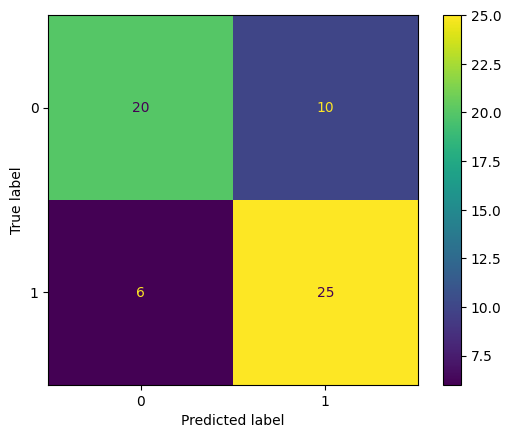

In [16]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

accuracy_test = accuracy_score(y_test, y_pred)
ANN_recall = round(recall_score(y_test, y_pred, average='weighted'),3)

print('accuracy:', accuracy_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

### So sánh các mô hình

In [17]:
recall_dict = {'SVM':svm_recall,
               'Gaussian Naive Bayes': gaussiannb_recall,
               'Bernoulli Naive Bayes': bernoullinb_recall,
               'XGBoost': xgb_recall,
               'Neural network': ANN_recall
               }

pr_df = pd.DataFrame(recall_dict,index=['Recall Score'])
pr_df

,SVM,Gaussian Naive Bayes,Bernoulli Naive Bayes,XGBoost,Neural network
Recall Score,0.803,0.754,0.82,0.77,0.738


## <center>```Tạo giao diện để ứng dụng các mô hình học máy```</center>

In [19]:
class Predictor:

    def has_disease(self, row):
        return 1 if self.predict(self, row) == 1 else 0

    @staticmethod
    def predict(self, row):
        thongtinbenhnhan = np.array(row).reshape(1, 20)
        thongtinbenhnhan = (thongtinbenhnhan - np.min(thongtinbenhnhan)) / (np.max(thongtinbenhnhan) - np.min(thongtinbenhnhan))
        self.model = pickle.load(open('BernoulliNB.h5', 'rb'))
        predicted = self.model.predict(thongtinbenhnhan)
        return predicted[0]

def insertMedicalRecord(data):
    server = 'NguyenNgocTriVi' 
    database = 'Heart' 
    username = 'sa' 
    password = '123' 
    conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = conn.cursor()
    sql = "INSERT INTO MedicalRecords (id, age, sex, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, ca, typical_angina_pain, atypical_angina_pain, non_anginal_pain, asymptomatic_pain, thalassemia_normal, thalassemia_fixed, thalassemia_reversable, upsloping_st, flat_st, downsloping_st, heart_disease) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
    cursor.executemany(sql, data)
    # Lưu thay đổi vào cơ sở dữ liệu
    conn.commit()
    # Đóng kết nối và con trỏ
    cursor.close()
    conn.close()

def insertPatient():
    if len(fullname.get()) != 0 and len(id.get()) != 0:
        row = [[id.get(), fullname.get()]]

        if insertPatientRecord(row):
            register_window = tk.Tk()
            register_window.title("Register Window")
            tk.Label(register_window, text = "Đăng ký thông tin bệnh nhân thành công!", font=("Calibri Bold", 20), fg="white", bg="green", height=2).grid(ipady = 24, ipadx = 24)
    
    else:
        register_window = tk.Tk()
        register_window.title("Register Window")
        tk.Label(register_window, text = "Đăng ký thông tin bệnh nhân thất bại!", font=("Calibri Bold", 20), fg="white", bg="maroon", height=2).grid(ipady = 24, ipadx = 24)
    return True

def insertPatientRecord(data):
    server = 'NguyenNgocTriVi' 
    database = 'Heart' 
    username = 'sa' 
    password = '123' 
    conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = conn.cursor()
    sql = "INSERT INTO Patient (id, fullname) VALUES (?, ?)"
    cursor.executemany(sql, data)
    # Lưu thay đổi vào cơ sở dữ liệu
    conn.commit()
    # Đóng kết nối và con trỏ
    cursor.close()
    conn.close()
    return True

def selectDB(data):
    server = 'NguyenNgocTriVi' 
    database = 'Heart' 
    username = 'sa' 
    password = '123' 
    conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = conn.cursor()
    sql = """Select p.id, fullname, age, sex, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, ca, typical_angina_pain, atypical_angina_pain, non_anginal_pain, asymptomatic_pain, thalassemia_normal, thalassemia_fixed, thalassemia_reversable, upsloping_st, flat_st, downsloping_st, heart_disease
            From Patient p, MedicalRecords mr Where mr.id = p.id And mr.id = ?"""
    cursor.executemany(sql, data)
    # Đóng kết nối và con trỏ
    return cursor
    
def History():
    Medical_Record_window = tk.Tk()
    Medical_Record_window.title("Medical Records Window")

    row = [[(id.get())]]

    e = tk.Label(Medical_Record_window, width=10, text='id',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=0)
    e = tk.Label(Medical_Record_window, width=10, text='fullname',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=1)
    e = tk.Label(Medical_Record_window, width=10, text='age',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=2)
    e = tk.Label(Medical_Record_window, width=10, text='sex',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=3)
    e = tk.Label(Medical_Record_window, width=10, text='trestbps',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=4)
    e = tk.Label(Medical_Record_window, width=10, text='chol',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=5)
    e = tk.Label(Medical_Record_window, width=10, text='fbs',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=6)
    e = tk.Label(Medical_Record_window, width=10, text='restecg',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=7)
    e = tk.Label(Medical_Record_window, width=10, text='thalach',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=8)
    e = tk.Label(Medical_Record_window, width=10, text='exang',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=9)
    e = tk.Label(Medical_Record_window, width=10, text='oldpeak',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=10)
    e = tk.Label(Medical_Record_window, width=10, text='ca',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=11)
    e = tk.Label(Medical_Record_window, width=10, text='typical_angina_pain',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=12)
    e = tk.Label(Medical_Record_window, width=10, text='atypical_angina_pain',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=13)
    e = tk.Label(Medical_Record_window, width=10, text='non_anginal_pain',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=14)
    e = tk.Label(Medical_Record_window, width=10, text='asymptomatic_pain',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=15)
    e = tk.Label(Medical_Record_window, width=10, text='thalassemia_normal',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=16)
    e = tk.Label(Medical_Record_window, width=10, text='thalassemia_fixed',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=17)
    e = tk.Label(Medical_Record_window, width=10, text='thalassemia_reversable',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=18)
    e = tk.Label(Medical_Record_window, width=10, text='upsloping_st',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=19)
    e = tk.Label(Medical_Record_window, width=10, text='flat_st',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=20)
    e = tk.Label(Medical_Record_window, width=10, text='downsloping_st',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=21)
    e = tk.Label(Medical_Record_window, width=10, text='heart_disease',borderwidth=2, relief='ridge',anchor='w',bg='royalblue')
    e.grid(row=0,column=22)

    i=1
    table = selectDB(row)
    print(table)
    for record in table: 
        for j in range(len(record)):
            e = tk.Entry(Medical_Record_window, width=10) 
            e.grid(row=i, column=j) 
            e.insert(tk.END, record[j])
        i = i + 1

    return True

def Predict():
    la=str()

    row=[[  id.get(),
            age.get(),
            gender.get(),
            tbps.get(),
            chol.get(),
            fbs.get(),
            restecg.get(),
            thalach.get(),
            exang.get(),
            oldpeak.get(),
            ca.get(),
            1 if cp.get() == 0 else 0,
            1 if cp.get() == 1 else 0,
            1 if cp.get() == 2 else 0,
            1 if cp.get() == 3 else 0,
            1 if thal.get() == 0 else 0,
            1 if thal.get() == 1 else 0,
            1 if thal.get() == 2 else 0,
            1 if slope.get() == 0 else 0,
            1 if slope.get() == 1 else 0,
            1 if slope.get() == 2 else 0,]]
    
    predictor = Predictor()
    o = predictor.has_disease(row)
    row[0].append(o)
    insertMedicalRecord(row)
    predict_window = tk.Tk()
    predict_window.title("Prediction Window")

    if (o == 1):
        la="Bị mắc bệnh tim"
        tk.Label(predict_window, text=la, font=("Calibri Bold", 20), fg="white", bg="maroon", height=2).grid(row=15, column=1, ipady = 24, ipadx = 24)
    else:
        la="Không có bệnh"
        tk.Label(predict_window, text=la, font=("Calibri Bold", 20), fg="white", bg="green", height=2).grid(row=15, column=1, ipady = 24, ipadx = 24)

    return True


root = tk.Tk()
root.option_add('*Font', 'calibri 12')
root.title("Chuẩn đoán bệnh tim")
tk.Label(root,text="""Mời bạn điền thông tin bệnh nhân""", font=("Calibri bold", 18 )).grid(row=0, column = 1, ipady=16, columnspan = 2)

tk.Label(root,text='Mã căn cước công dân',padx=20).grid(row=1,column=0, ipady=8)
id = tk.StringVar()
tk.Entry(root,textvariable=id).grid(row=1,column=1, ipady=8)
tk.Button(root, text='Xem lịch sử bệnh án của bệnh nhân', command = History).grid(row=1, column=2, ipady = 8, sticky=tk.W, pady=4)
tk.Button(root, text='Đăng ký thông tin bệnh nhân', command = insertPatient).grid(row=1, column=3, ipady = 8, sticky=tk.W, pady=4)

tk.Label(root,text='Họ và tên',padx=20).grid(row=2,column=0, ipady=8)
fullname = tk.StringVar()
tk.Entry(root,textvariable=fullname).grid(row=2,column=1, ipady=8)

tk.Label(root,text='Tuổi',padx=20).grid(row=2,column=2, ipady=8)
age = tk.IntVar()
tk.Entry(root,textvariable=age).grid(row=2,column=3, ipady=8)

tk.Label(root,text="""Giới tính""",padx=20).grid(row=3,column=0)
gender = tk.IntVar()
tk.Radiobutton(root,text="Nam",padx=20,variable=gender,value=1).grid(row=3,column=1, ipady = 8)
tk.Radiobutton(root,text="Nữ",padx=20,variable=gender,value=0).grid(row=3,column=2, ipady = 8)

tk.Label(root,text='Loại đau ngực').grid(row=4,column=0, ipady = 8)
cp = tk.IntVar()
tk.Radiobutton(root,text="Đau thắt ngực rõ ràng",padx=20,variable=cp,value=0).grid(row=4,column=1, ipady = 8)
tk.Radiobutton(root,text="đau thắt ngực không rõ ràng",padx=20,variable=cp,value=1).grid(row=4,column=2, ipady = 8)
tk.Radiobutton(root,text="Không đau thắt ngực",padx=20,variable=cp,value=2).grid(row=4,column=3, ipady = 8)
tk.Radiobutton(root,text="Không triệu chứng",padx=20,variable=cp,value=3).grid(row=4,column=4, ipady = 8)

tk.Label(root,text='Huyết áp lúc nghỉ ngơi:').grid(row=5,column=0, ipady = 8)
tbps = tk.IntVar()
tk.Entry(root,textvariable=tbps).grid(row=5,column=1, ipady = 8)

tk.Label(root,text='Cholestoral trong huyết thanh tính bằng mg/dl').grid(row=6,column=0, ipady = 8)
chol = tk.IntVar()
tk.Entry(root,textvariable=chol).grid(row=6,column=1, ipady = 8)

tk.Label(root,text="""Đường huyết lúc đói > 120 mg/dl)""",padx=20).grid(row=7,column=0, ipady = 8)
fbs=tk.IntVar()
tk.Radiobutton(root,text="Đúng",padx=20,variable=fbs,value=1).grid(row=7,column=1, ipady = 8)
tk.Radiobutton(root,text="Sai",padx=20,variable=fbs,value=0).grid(row=7,column=2, ipady = 8)

tk.Label(root,text="""Kết quả điện tâm đồ lúc nghỉ""",padx=20).grid(row=8,column=0, ipady = 8)
restecg=tk.IntVar()
tk.Radiobutton(root,text="0",padx=20,variable=restecg,value=0).grid(row=8,column=1, ipady = 8)
tk.Radiobutton(root,text="1",padx=20,variable=restecg,value=1).grid(row=8,column=2, ipady = 8)
tk.Radiobutton(root,text="2",padx=20,variable=restecg,value=2).grid(row=8,column=3, ipady = 8)

tk.Label(root,text='Nhịp tim tối đa').grid(row=9,column=0, ipady = 8)
thalach = tk.IntVar()
tk.Entry(root,textvariable=thalach).grid(row=9,column=1, ipady = 8)

tk.Label(root,text="""Đau thắt ngực khi tập thể dục """,padx=20).grid(row=10,column=0, ipady = 8)
exang=tk.IntVar()
tk.Radiobutton(root,text="Có",padx=20,variable=exang,value=1).grid(row=10,column=1, ipady = 8)
tk.Radiobutton(root,text="Không",padx=20,variable=exang,value=0).grid(row=10,column=2, ipady = 8)

tk.Label(root,text='ST ức chế do luyện tập so với khi nghỉ').grid(row=11,column=0, ipady = 8)
oldpeak = tk.DoubleVar()
tk.Entry(root,textvariable=oldpeak).grid(row=11,column=1, ipady = 8)

tk.Label(root,text="""Độ dốc của đoạn ST tập luyện đỉnh cao""",padx=20).grid(row=12,column=0, ipady = 8)
slope=tk.IntVar()
tk.Radiobutton(root,text="Dốc lên",padx=20,variable=slope,value=0).grid(row=12,column=1, ipady = 8)
tk.Radiobutton(root,text="Bằng phẳng",padx=20,variable=slope,value=1).grid(row=12,column=2, ipady = 8)
tk.Radiobutton(root,text="Dốc xuống",padx=20,variable=slope,value=2).grid(row=12,column=3, ipady = 8)

tk.Label(root,text="""Số lượng mạch chính được tô màu bằng phương pháp nội soi""",padx=20).grid(row=13,column=0, ipady = 8)
ca=tk.IntVar()
tk.Radiobutton(root,text="0",padx=20,variable=ca,value=0).grid(row=13,column=1, ipady = 8)
tk.Radiobutton(root,text="1",padx=20,variable=ca,value=1).grid(row=13,column=2, ipady = 8)
tk.Radiobutton(root,text="2",padx=20,variable=ca,value=2).grid(row=13,column=3, ipady = 8)
tk.Radiobutton(root,text="3",padx=20,variable=ca,value=3).grid(row=13,column=4, ipady = 8)

tk.Label(root,text="""Bệnh thiếu máu Thalassemia""",padx=20).grid(row=14,column=0, ipady = 8)
thal=tk.IntVar()
tk.Radiobutton(root,text="Không có",padx=20,variable=thal,value=0).grid(row=14,column=1, ipady = 8)
tk.Radiobutton(root,text="Bẩm sinh",padx=20,variable=thal,value=1).grid(row=14,column=2, ipady = 8)
tk.Radiobutton(root,text="Có thể chữa",padx=20,variable=thal,value=2).grid(row=14,column=3, ipady = 8)

tk.Button(root, text='Dự đoán', command = Predict).grid(row=15, column=3, ipady = 8, sticky=tk.W, pady=4)


root.mainloop()